In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 7
commitnumber = e2a721f
conc = 1.8e-06
dv = 0.05
klin = 0
molecule = ch4
ng_adju = [0, 0]
ng_refs = [8, 7]
nv = 20
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (500, 250)]
tsfc = 300
vmax = 1380
vmin = 1215
w_diffuse = [(1, 1, 1, 1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1)]
wgt = [(1, 1, 1, 1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

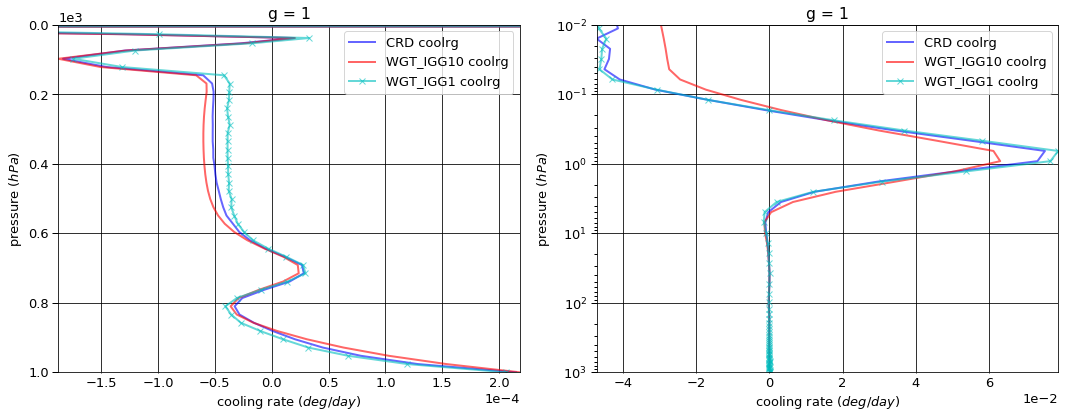

# Figure: cooling rate g-group 2

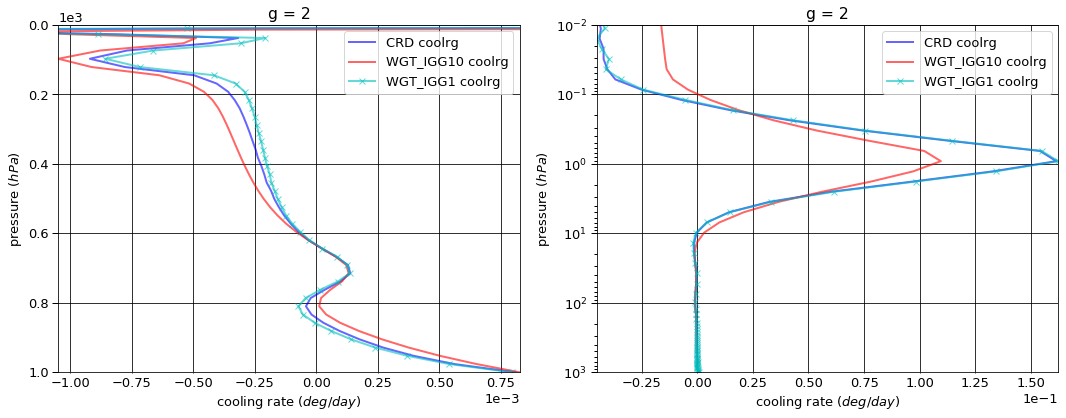

# Figure: cooling rate g-group 3

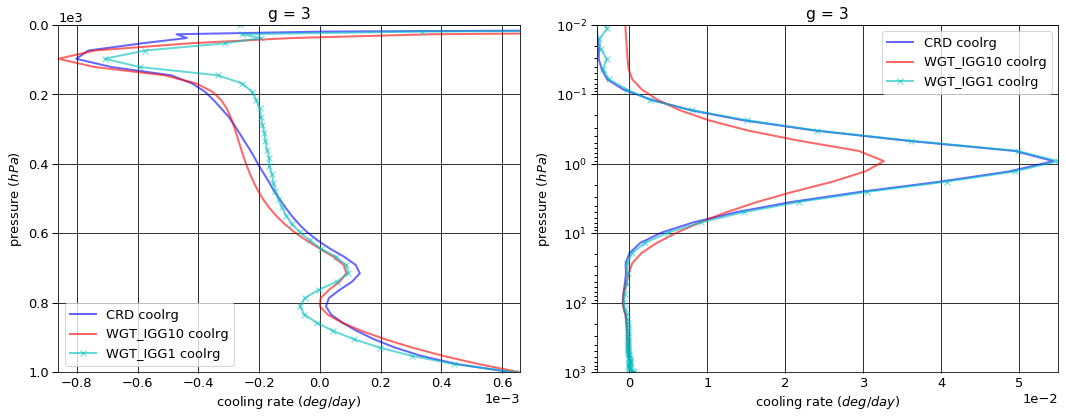

# Figure: cooling rate g-group 4

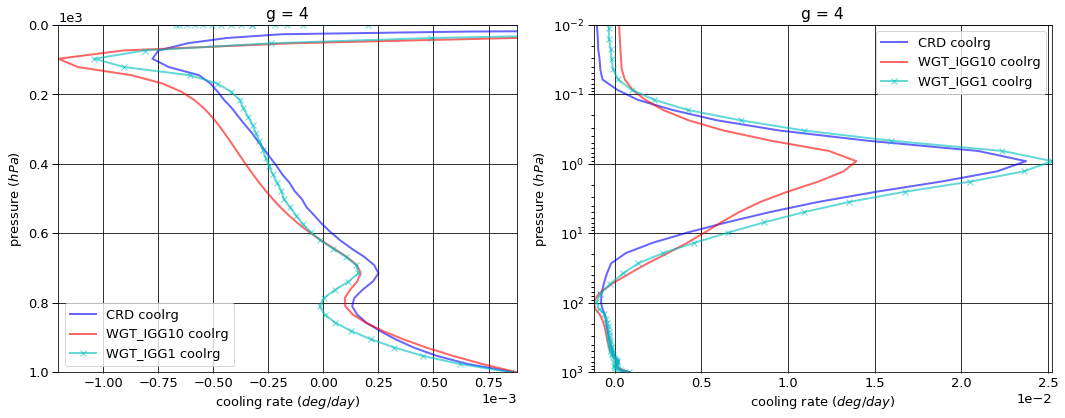

# Figure: cooling rate g-group 5

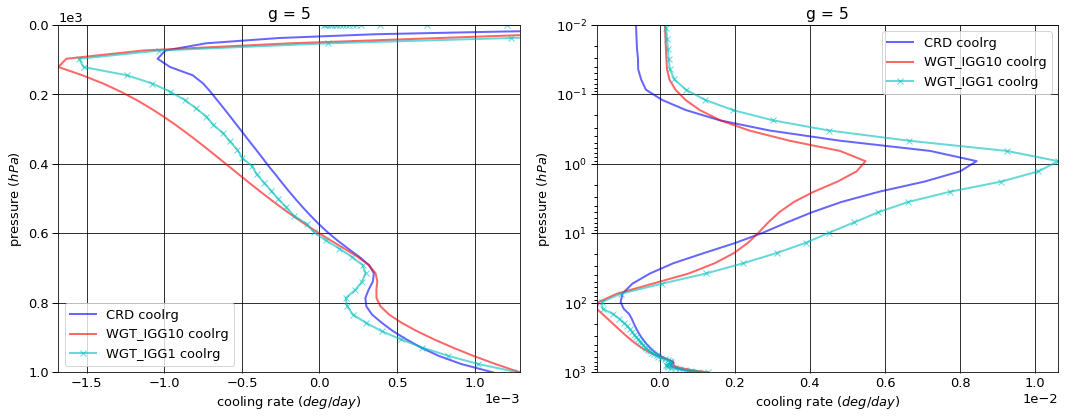

# Figure: cooling rate g-group 6

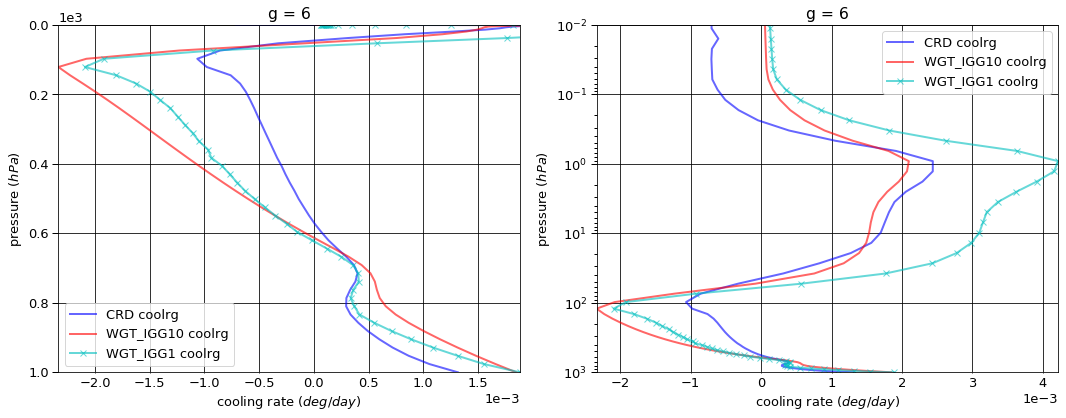

# Figure: cooling rate g-group 7

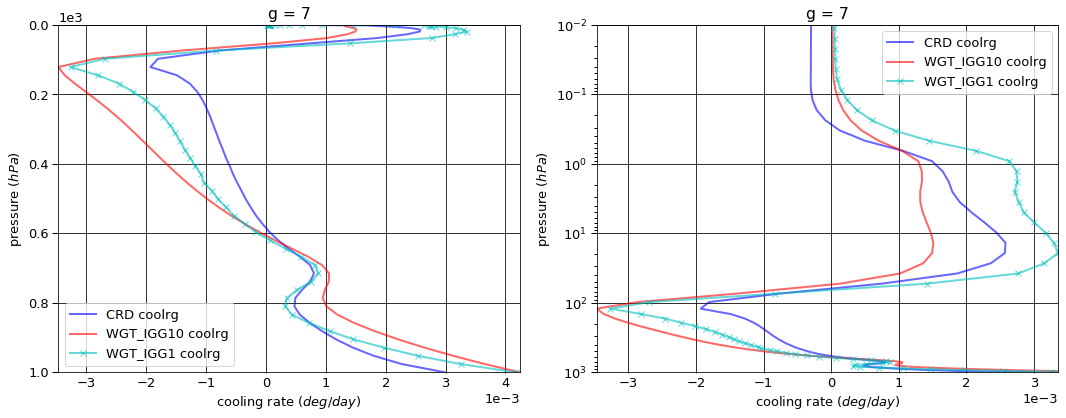

# Figure: cooling rate g-group 8

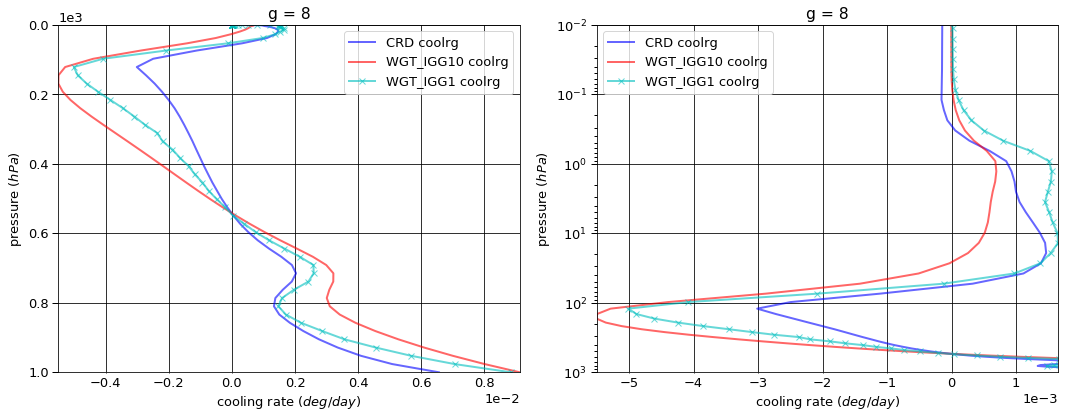

# Figure: cooling rate g-group 9

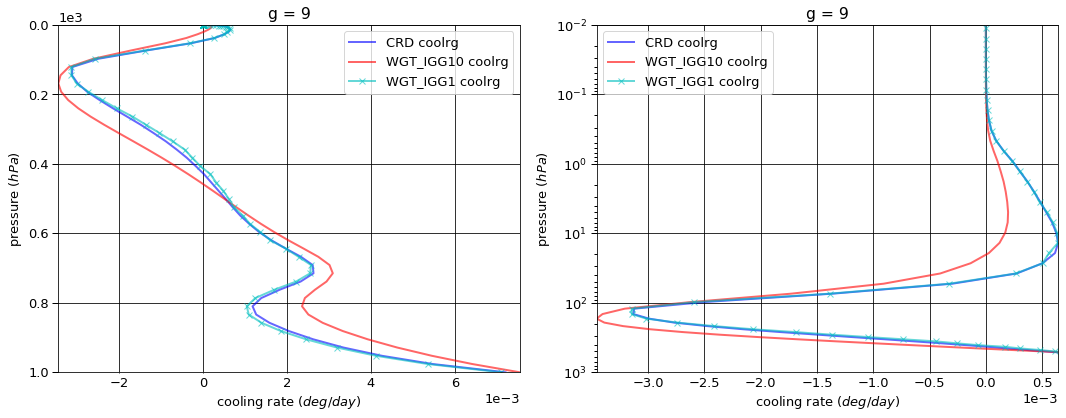

# Figure: cooling rate g-group 10

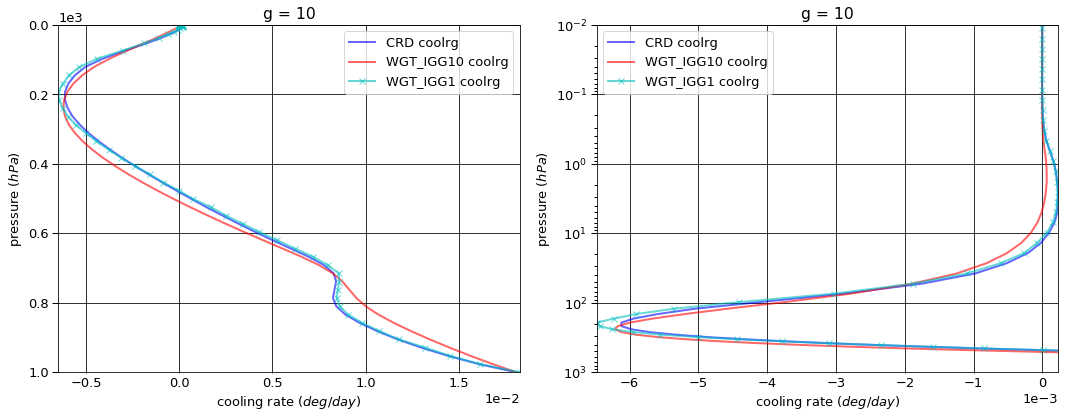

# Figure: cooling rate g-group 11

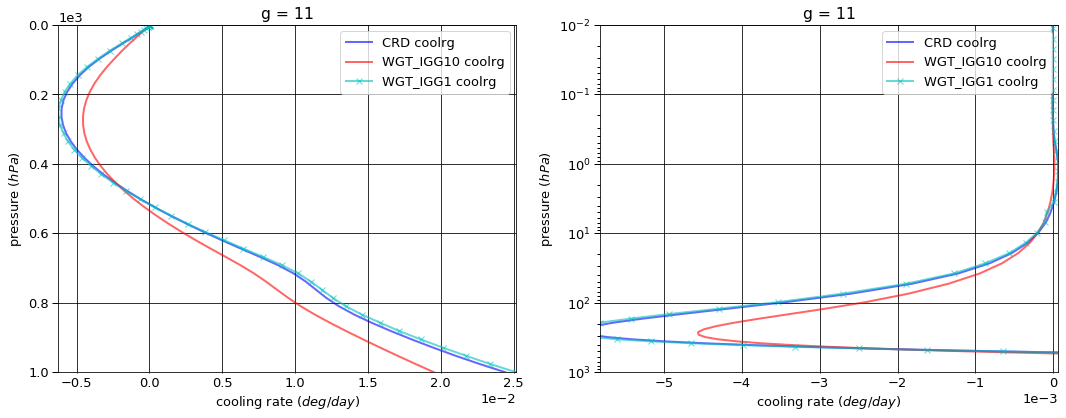

# Figure: cooling rate g-group 12

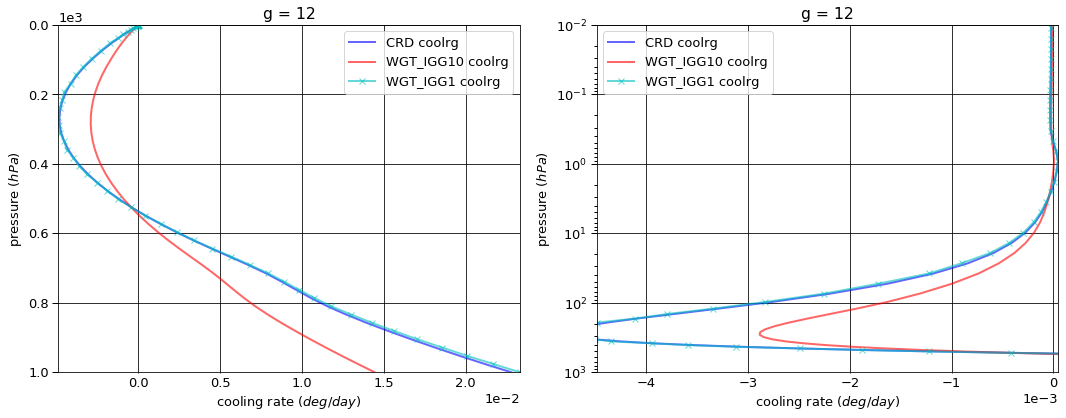

# Figure: cooling rate g-group 13

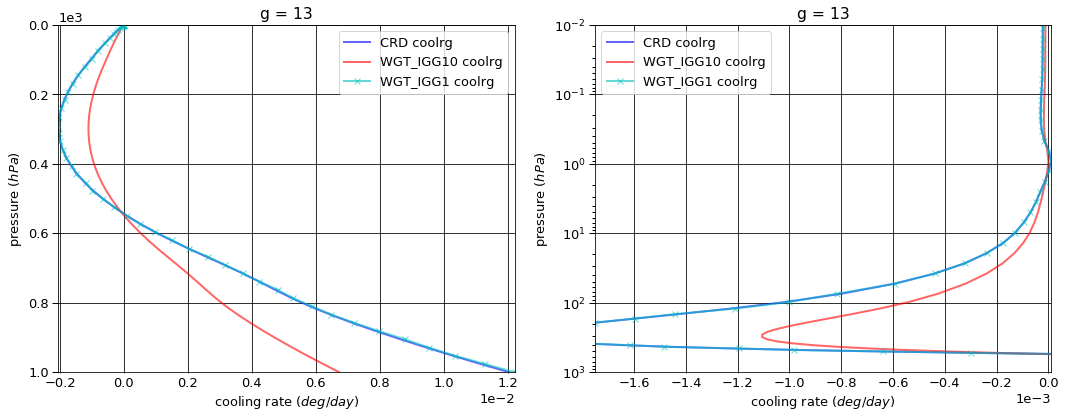

# Figure: cooling rate g-group 14

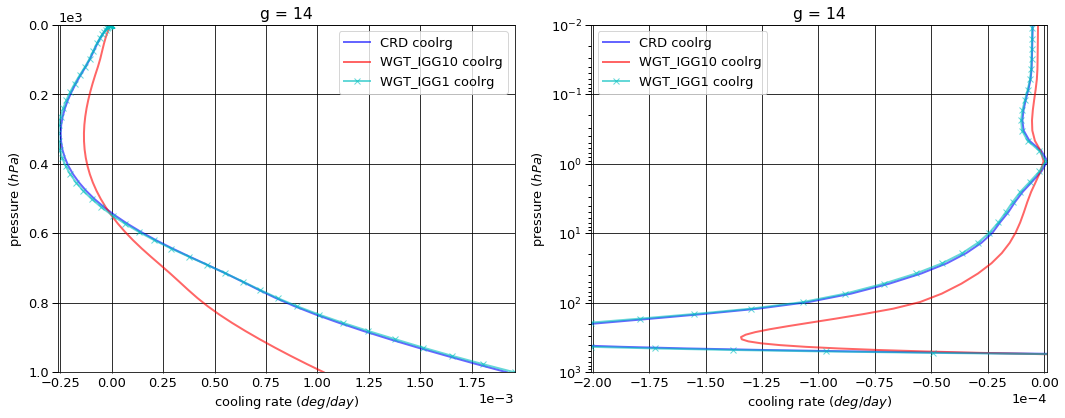

# Figure: cooling rate g-group 15

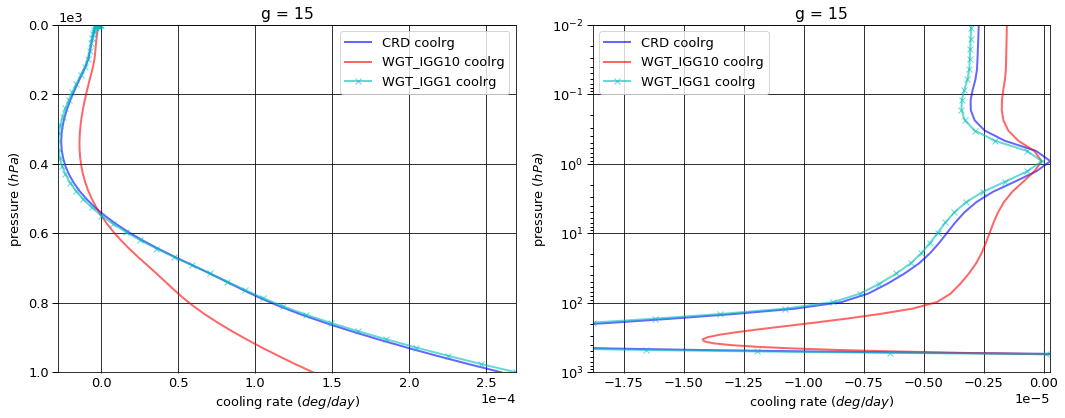

# Figure: cooling rate g-group total

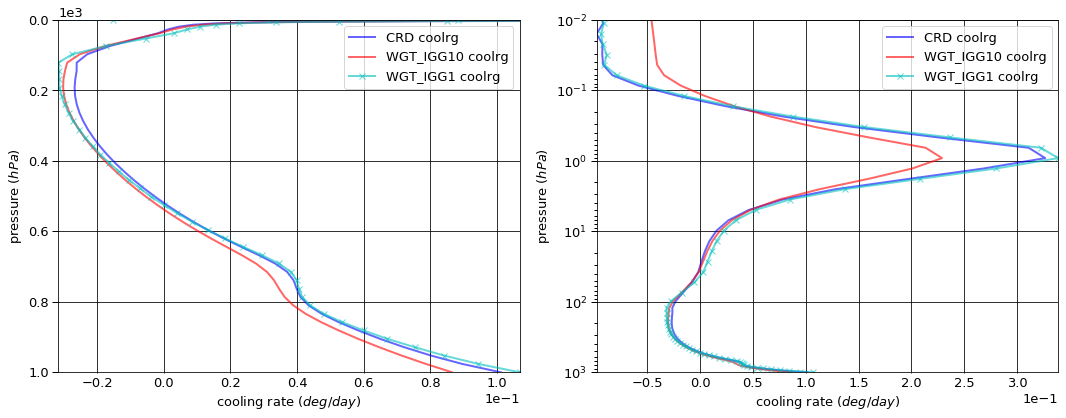

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.010071  0.000000 -0.010071
   1013.0   76    -0.030767  0.028639 -0.002128
2  0.0      1     -0.034236  0.000000 -0.034236
   1013.0   76    -0.110532  0.100085 -0.010446
3  0.0      1     -0.021091  0.000000 -0.021091
   1013.0   76    -0.088703  0.076212 -0.012491
4  0.0      1     -0.027720  0.000000 -0.027720
   1013.0   76    -0.116502  0.093974 -0.022528
5  0.0      1     -0.052319  0.000000 -0.052319
   1013.0   76    -0.164788  0.110105 -0.054683
6  0.0      1     -0.125881  0.000000 -0.125881
   1013.0   76    -0.251362  0.126808 -0.124553
7  0.0      1     -0.256103  0.000000 -0.256103
   1013.0   76    -0.552541  0.305983 -0.246558
8  0.0      1     -0.530714  0.000000 -0.530714
   1013.0   76    -1.127602  0.640868 -0.486734
9  0.0      1     -0.173745  0.000000 -0.173745
   1013.0   76    -0.902372  0.797152 -0.105221
10 0.0      1     -0.879284  0.000000 -0.879284
   1013.0   76    -2.007945  1.426236 -0.581709
11 0.0      1     -2.412313  0.000000 -2.412313
   1013.0   76    -3.325197  1.363751 -1.961446
12 0.0      1     -5.666615  0.000000 -5.666615
   1013.0   76    -6.313251  1.044386 -5.268864
13 0.0      1     -7.604857  0.000000 -7.604857
   1013.0   76    -7.884260  0.496332 -7.387928
14 0.0      1     -3.021752  0.000000 -3.021752
   1013.0   76    -3.058284  0.073230 -2.985054
15 0.0      1     -1.024437  0.000000 -1.024437
   1013.0   76    -1.028640  0.009335 -1.019305


WGT_IGG10


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.010564  0.000000 -0.010564
   1013.0   76    -0.029966  0.027537 -0.002428
2  0.0      1     -0.031102  0.000000 -0.031102
   1013.0   76    -0.108852  0.096141 -0.012711
3  0.0      1     -0.017413  0.000000 -0.017413
   1013.0   76    -0.088274  0.077498 -0.010776
4  0.0      1     -0.015118  0.000000 -0.015118
   1013.0   76    -0.114146  0.097853 -0.016292
5  0.0      1     -0.018352  0.000000 -0.018352
   1013.0   76    -0.165243  0.129963 -0.035280
6  0.0      1     -0.028526  0.000000 -0.028526
   1013.0   76    -0.250376  0.184648 -0.065728
7  0.0      1     -0.063383  0.000000 -0.063383
   1013.0   76    -0.550153  0.447694 -0.102459
8  0.0      1     -0.244474  0.000000 -0.244474
   1013.0   76    -1.120219  0.891437 -0.228782
9  0.0      1     -0.223332  0.000000 -0.223332
   1013.0   76    -0.892204  0.750566 -0.141638
10 0.0      1     -1.074857  0.000000 -1.074857
   1013.0   76    -1.988942  1.214752 -0.774190
11 0.0      1     -2.708915  0.000000 -2.708915
   1013.0   76    -3.313905  0.950851 -2.363054
12 0.0      1     -5.917674  0.000000 -5.917674
   1013.0   76    -6.286187  0.613986 -5.672201
13 0.0      1     -7.722089  0.000000 -7.722089
   1013.0   76    -7.869697  0.267216 -7.602481
14 0.0      1     -3.099926  0.000000 -3.099926
   1013.0   76    -3.119291  0.038426 -3.080865
15 0.0      1     -1.063055  0.000000 -1.063055
   1013.0   76    -1.065291  0.004866 -1.060425


WGT_IGG1


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.010243  0.000000 -0.010243
   1013.0   76    -0.029966  0.028293 -0.001673
2  0.0      1     -0.034679  0.000000 -0.034679
   1013.0   76    -0.108852  0.100157 -0.008694
3  0.0      1     -0.020955  0.000000 -0.020955
   1013.0   76    -0.088274  0.080881 -0.007393
4  0.0      1     -0.018551  0.000000 -0.018551
   1013.0   76    -0.114146  0.103029 -0.011116
5  0.0      1     -0.018680  0.000000 -0.018680
   1013.0   76    -0.165243  0.141160 -0.024083
6  0.0      1     -0.024338  0.000000 -0.024338
   1013.0   76    -0.250376  0.204777 -0.045599
7  0.0      1     -0.050364  0.000000 -0.050364
   1013.0   76    -0.550153  0.480193 -0.069961
8  0.0      1     -0.172748  0.000000 -0.172748
   1013.0   76    -1.120219  0.965981 -0.154237
9  0.0      1     -0.161601  0.000000 -0.161601
   1013.0   76    -0.892204  0.797950 -0.094254
10 0.0      1     -0.831046  0.000000 -0.831046
   1013.0   76    -1.988942  1.457655 -0.531287
11 0.0      1     -2.381479  0.000000 -2.381479
   1013.0   76    -3.313905  1.397846 -1.916059
12 0.0      1     -5.633332  0.000000 -5.633332
   1013.0   76    -6.286187  1.060384 -5.225803
13 0.0      1     -7.590029  0.000000 -7.590029
   1013.0   76    -7.869697  0.499554 -7.370143
14 0.0      1     -3.081493  0.000000 -3.081493
   1013.0   76    -3.119291  0.074446 -3.044845
15 0.0      1     -1.060870  0.000000 -1.060870
   1013.0   76    -1.065291  0.009594 -1.055697


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.000493  0.000000 -0.000493
   1013.0   76     0.000801 -0.001101 -0.000300
2  0.0      1      0.003134  0.000000  0.003134
   1013.0   76     0.001680 -0.003944 -0.002264
3  0.0      1      0.003678  0.000000  0.003678
   1013.0   76     0.000428  0.001286  0.001714
4  0.0      1      0.012601  0.000000  0.012601
   1013.0   76     0.002357  0.003879  0.006236
5  0.0      1      0.033967  0.000000  0.033967
   1013.0   76    -0.000455  0.019858  0.019403
6  0.0      1      0.097356  0.000000  0.097356
   1013.0   76     0.000986  0.057840  0.058826
7  0.0      1      0.192720  0.000000  0.192720
   1013.0   76     0.002388  0.141711  0.144099
8  0.0      1      0.286240  0.000000  0.286240
   1013.0   76     0.007383  0.250569  0.257953
9  0.0      1     -0.049587  0.000000 -0.049587
   1013.0   76     0.010168 -0.046586 -0.036418
10 0.0      1     -0.195573  0.000000 -0.195573
   1013.0   76     0.019003 -0.211484 -0.192481
11 0.0      1     -0.296602  0.000000 -0.296602
   1013.0   76     0.011293 -0.412900 -0.401608
12 0.0      1     -0.251059  0.000000 -0.251059
   1013.0   76     0.027064 -0.430400 -0.403336
13 0.0      1     -0.117232  0.000000 -0.117232
   1013.0   76     0.014563 -0.229116 -0.214553
14 0.0      1     -0.078174  0.000000 -0.078174
   1013.0   76    -0.061007 -0.034804 -0.095811
15 0.0      1     -0.038618  0.000000 -0.038618
   1013.0   76    -0.036651 -0.004469 -0.041120


WGT_IGG1 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.000172  0.000000 -0.000172
   1013.0   76     0.000801 -0.000346  0.000455
2  0.0      1     -0.000443  0.000000 -0.000443
   1013.0   76     0.001680  0.000072  0.001752
3  0.0      1      0.000136  0.000000  0.000136
   1013.0   76     0.000428  0.004669  0.005097
4  0.0      1      0.009168  0.000000  0.009168
   1013.0   76     0.002357  0.009055  0.011411
5  0.0      1      0.033639  0.000000  0.033639
   1013.0   76    -0.000455  0.031056  0.030600
6  0.0      1      0.101543  0.000000  0.101543
   1013.0   76     0.000986  0.077968  0.078954
7  0.0      1      0.205739  0.000000  0.205739
   1013.0   76     0.002388  0.174209  0.176597
8  0.0      1      0.357965  0.000000  0.357965
   1013.0   76     0.007383  0.325113  0.332497
9  0.0      1      0.012144  0.000000  0.012144
   1013.0   76     0.010168  0.000798  0.010966
10 0.0      1      0.048238  0.000000  0.048238
   1013.0   76     0.019003  0.031419  0.050422
11 0.0      1      0.030834  0.000000  0.030834
   1013.0   76     0.011293  0.034095  0.045388
12 0.0      1      0.033284  0.000000  0.033284
   1013.0   76     0.027064  0.015998  0.043062
13 0.0      1      0.014828  0.000000  0.014828
   1013.0   76     0.014563  0.003222  0.017785
14 0.0      1     -0.059741  0.000000 -0.059741
   1013.0   76    -0.061007  0.001216 -0.059790
15 0.0      1     -0.036434  0.000000 -0.036434
   1013.0   76    -0.036651  0.000259 -0.036392

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1     -5.025075e-02
   1001.112500 75     2.148391e-04
2  0.000312    1     -4.988844e-02
   1001.112500 75     8.090251e-04
3  0.000312    1     -5.148616e-03
   1001.112500 75     6.314782e-04
4  0.000312    1      9.603030e-06
   1001.112500 75     8.681983e-04
5  0.000312    1     -5.509379e-04
   1001.112500 75     1.117094e-03
6  0.000312    1     -7.098508e-04
   1001.112500 75     1.315132e-03
7  0.000312    1     -2.836549e-04
   1001.112500 75     2.988394e-03
8  0.000312    1     -1.362910e-04
   1001.112500 75     6.563545e-03
9  0.000312    1     -8.693714e-08
   1001.112500 75     7.211382e-03
10 0.000312    1     -2.343383e-06
   1001.112500 75     1.807338e-02
11 0.000312    1     -6.617134e-06
   1001.112500 75     2.445538e-02
12 0.000312    1     -2.106662e-05
   1001.112500 75     2.278319e-02
13 0.000312    1     -1.932354e-05
   1001.112500 75     1.205753e-02
14 0.000312    1     -4.342700e-06
   1001.112500 75     1.920365e-03
15 0.000312    1     -2.567385e-06
   1001.112500 75     2.597954e-04


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1     -3.483696e-02
   1001.112500 75     2.181855e-04
2  0.000312    1     -2.008053e-02
   1001.112500 75     8.267924e-04
3  0.000312    1     -1.107153e-03
   1001.112500 75     6.583407e-04
4  0.000312    1      5.891890e-05
   1001.112500 75     8.787486e-04
5  0.000312    1      6.280984e-05
   1001.112500 75     1.291709e-03
6  0.000312    1      2.491607e-05
   1001.112500 75     1.847353e-03
7  0.000312    1      7.083563e-06
   1001.112500 75     4.240315e-03
8  0.000312    1     -9.600124e-06
   1001.112500 75     9.128566e-03
9  0.000312    1     -1.604060e-07
   1001.112500 75     7.552321e-03
10 0.000312    1     -1.662060e-06
   1001.112500 75     1.807064e-02
11 0.000312    1     -4.600665e-06
   1001.112500 75     1.954571e-02
12 0.000312    1     -1.245804e-05
   1001.112500 75     1.444861e-02
13 0.000312    1     -1.036300e-05
   1001.112500 75     6.740234e-03
14 0.000312    1     -2.307444e-06
   1001.112500 75     1.030972e-03
15 0.000312    1     -1.453073e-06
   1001.112500 75     1.374703e-04


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1     -5.465637e-02
   1001.112500 75     2.063197e-04
2  0.000312    1     -4.909977e-02
   1001.112500 75     7.949843e-04
3  0.000312    1     -5.004028e-03
   1001.112500 75     6.410702e-04
4  0.000312    1     -6.713119e-04
   1001.112500 75     8.529312e-04
5  0.000312    1      2.817169e-05
   1001.112500 75     1.277562e-03
6  0.000312    1      6.340279e-05
   1001.112500 75     1.881188e-03
7  0.000312    1      2.583409e-05
   1001.112500 75     4.172835e-03
8  0.000312    1      3.597068e-06
   1001.112500 75     8.844771e-03
9  0.000312    1     -1.245020e-08
   1001.112500 75     7.108133e-03
10 0.000312    1     -1.579293e-06
   1001.112500 75     1.825933e-02
11 0.000312    1     -6.349472e-06
   1001.112500 75     2.519506e-02
12 0.000312    1     -2.085284e-05
   1001.112500 75     2.330322e-02
13 0.000312    1     -1.912693e-05
   1001.112500 75     1.221821e-02
14 0.000312    1     -4.472940e-06
   1001.112500 75     1.957180e-03
15 0.000312    1     -2.867252e-06
   1001.112500 75     2.693223e-04


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.541379e-02
   1001.112500 75     3.346410e-06
2  0.000312    1      2.980791e-02
   1001.112500 75     1.776732e-05
3  0.000312    1      4.041462e-03
   1001.112500 75     2.686256e-05
4  0.000312    1      4.931587e-05
   1001.112500 75     1.055027e-05
5  0.000312    1      6.137477e-04
   1001.112500 75     1.746159e-04
6  0.000312    1      7.347669e-04
   1001.112500 75     5.322216e-04
7  0.000312    1      2.907384e-04
   1001.112500 75     1.251921e-03
8  0.000312    1      1.266909e-04
   1001.112500 75     2.565021e-03
9  0.000312    1     -7.346888e-08
   1001.112500 75     3.409387e-04
10 0.000312    1      6.813230e-07
   1001.112500 75    -2.741000e-06
11 0.000312    1      2.016469e-06
   1001.112500 75    -4.909670e-03
12 0.000312    1      8.608584e-06
   1001.112500 75    -8.334578e-03
13 0.000312    1      8.960543e-06
   1001.112500 75    -5.317292e-03
14 0.000312    1      2.035256e-06
   1001.112500 75    -8.893924e-04
15 0.000312    1      1.114312e-06
   1001.112500 75    -1.223251e-04


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -4.405621e-03
   1001.112500 75    -8.519430e-06
2  0.000312    1      7.886740e-04
   1001.112500 75    -1.404075e-05
3  0.000312    1      1.445874e-04
   1001.112500 75     9.592000e-06
4  0.000312    1     -6.809149e-04
   1001.112500 75    -1.526706e-05
5  0.000312    1      5.791096e-04
   1001.112500 75     1.604688e-04
6  0.000312    1      7.732536e-04
   1001.112500 75     5.660565e-04
7  0.000312    1      3.094889e-04
   1001.112500 75     1.184441e-03
8  0.000312    1      1.398881e-04
   1001.112500 75     2.281226e-03
9  0.000312    1      7.448694e-08
   1001.112500 75    -1.032491e-04
10 0.000312    1      7.640907e-07
   1001.112500 75     1.859450e-04
11 0.000312    1      2.676617e-07
   1001.112500 75     7.396810e-04
12 0.000312    1      2.137810e-07
   1001.112500 75     5.200350e-04
13 0.000312    1      1.966100e-07
   1001.112500 75     1.606860e-04
14 0.000312    1     -1.302404e-07
   1001.112500 75     3.681580e-05
15 0.000312    1     -2.998675e-07
   1001.112500 75     9.526900e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-21.841137,0.000000,-21.841137
1013.0,76,-26.962746,6.693097,-20.269649



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.238780,0.000000,-22.238780
1013.0,76,-26.962746,5.793435,-21.169311



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-21.090408,0.000000,-21.090408
1013.0,76,-26.962746,7.401901,-19.560845



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-3.976427e-01,0.000000,-0.397643
1013.0,76,7.000004e-09,-0.899662,-0.899662



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,7.507293e-01,0.000000,0.750729
1013.0,76,7.000004e-09,0.708804,0.708804


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.107015
1001.112500,75,0.101269



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.055914
1001.112500,75,0.086616



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.109366
1001.112500,75,0.106982



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.051102
1001.112500,75,-0.014653



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.002350
1001.112500,75,0.005713


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001212,0.001111
2,0.004242,0.004037
3,0.003333,0.003274
4,0.004545,0.004233
5,0.006061,0.006129
6,0.009394,0.009286
7,0.020606,0.020404
8,0.042424,0.041547
9,0.034242,0.033090


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.764177e-18
2,2.153649e-18
3,5.973852e-19
4,1.657044e-19
5,4.596354e-20
6,1.274950e-20
7,3.536491e-21
8,9.809617e-22
9,9.486845e-20


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.764177e-18,NaN,0.001212,0.001111,0.001212,0.001111,1.0
2,2.153649e-18,0.277383,0.004242,0.004037,0.005455,0.005149,1.0
3,5.973852e-19,0.277383,0.003333,0.003274,0.008788,0.008422,1.0
4,1.657044e-19,0.277383,0.004545,0.004233,0.013333,0.012656,1.0
5,4.596354e-20,0.277383,0.006061,0.006129,0.019394,0.018784,1.0
6,1.274950e-20,0.277383,0.009394,0.009286,0.028788,0.028070,1.0
7,3.536491e-21,0.277383,0.020606,0.020404,0.049394,0.048475,1.0
8,9.809617e-22,0.277383,0.042424,0.041547,0.091818,0.090022,1.0
9,9.486845e-20,96.709632,0.034242,0.033090,0.126061,0.123112,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
